First we import libraries 

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Then we are reading the data

In [2]:
# loading the data
df = pd.read_excel(r'baseline_database_codes_RA_group3.xlsx')


In this part we only focus on the FFQs and remove food items with different intake measures

In [3]:
# Include patient ID in the new database
columns_to_select = ['ID_paziente'] + df.loc[:, 'carni_rosse':'margarina'].columns.tolist()
columns_to_exclude = ['acqua', 'sale_cottura', 'sale_dopo_cottura', 'zucchero_aggiunto', 'dolcificante', 'olio_oliva', 'olio_semi']

for col in columns_to_exclude:
    if col in columns_to_select:
        columns_to_select.remove(col)

# Create new database with selected columns including patient ID
new_database = df[columns_to_select].copy()

In [4]:
new_database.shape

(365, 103)

We will see if we have any missing values or not 

In [5]:
# Check for missing values in new_database
missing_values = new_database.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Get total number of missing values
total_missing = missing_values.sum()
print(f"\nTotal missing values: {total_missing}")

# Get percentage of missing values
missing_percentage = (missing_values / len(new_database)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage[missing_percentage > 0])

Missing values per column:
Series([], dtype: int64)

Total missing values: 0

Percentage of missing values per column:
Series([], dtype: float64)


In [6]:
new_database.head()

,ID_paziente,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,...,tavola_calda,latte,latte_soia_risa,yogurt,formaggio_giallo,ricotta_formaggi_magri,mozzarella,formaggio.spalmabile,burro,margarina
0,1,2-3/settimana,2/mese,mai,2/mese,2-3/settimana,2/mese,mai,mai,mai,...,mai,1/die,mai,mai,1/settimana,1/settimana,1/settimana,1/settimana,1/mese,mai
1,2,2-3/settimana,2/mese,mai,2-3/settimana,1/settimana,2/mese,mai,mai,1/mese,...,mai,2-3/settimana,1/mese,2-3/settimana,1/settimana,1/settimana,1/settimana,1/settimana,1/settimana,mai
2,3,2-3/settimana,2-3/settimana,mai,2-3/settimana,1/mese,2/mese,mai,2/mese,2-3/settimana,...,mai,1/mese,mai,2-3/settimana,mai,mai,1/settimana,mai,2/mese,2/mese
3,4,2-3/settimana,mai,mai,2-3/settimana,2-3/settimana,1/settimana,mai,1/mese,mai,...,mai,mai,1/die,1/die,mai,2-3/settimana,1/settimana,2/mese,2/mese,mai
4,5,1/settimana,mai,mai,2/mese,1/mese,mai,2/mese,1/mese,1/mese,...,mai,1/die,mai,2-3/settimana,2/mese,2-3/settimana,2-3/settimana,1/mese,1/mese,mai


We have to first deal with "mai" or "never" and set it to zero 

In [7]:
# Replace "mai" with 0 in all columns except ID_paziente
for column in new_database.columns:
    if column != 'ID_paziente':
        new_database[column] = new_database[column].replace('mai', 0)

checking to see if it worked or not


In [8]:
new_database.head()

,ID_paziente,carni_rosse,maiale,fast.food,carni_bianca,carni_processata,merluzzo_sogliola,sgombro_lanzardo,pesce_spada,masculino_alici,...,tavola_calda,latte,latte_soia_risa,yogurt,formaggio_giallo,ricotta_formaggi_magri,mozzarella,formaggio.spalmabile,burro,margarina
0,1,2-3/settimana,2/mese,0,2/mese,2-3/settimana,2/mese,0,0,0,...,0,1/die,0,0,1/settimana,1/settimana,1/settimana,1/settimana,1/mese,0
1,2,2-3/settimana,2/mese,0,2-3/settimana,1/settimana,2/mese,0,0,1/mese,...,0,2-3/settimana,1/mese,2-3/settimana,1/settimana,1/settimana,1/settimana,1/settimana,1/settimana,0
2,3,2-3/settimana,2-3/settimana,0,2-3/settimana,1/mese,2/mese,0,2/mese,2-3/settimana,...,0,1/mese,0,2-3/settimana,0,0,1/settimana,0,2/mese,2/mese
3,4,2-3/settimana,0,0,2-3/settimana,2-3/settimana,1/settimana,0,1/mese,0,...,0,0,1/die,1/die,0,2-3/settimana,1/settimana,2/mese,2/mese,0
4,5,1/settimana,0,0,2/mese,1/mese,0,2/mese,1/mese,1/mese,...,0,1/die,0,2-3/settimana,2/mese,2-3/settimana,2-3/settimana,1/mese,1/mese,0


now we need to take all the values and convert them to a daily 24h intake


In [9]:
# Define the replacement dictionary for converting to daily intake
replacement_dict = {
    "1/die": 1,
    "2-3/die": 2.5,
    "4-5/die": 4.5,
    "1/settimana": 1 / 7,
    "2-3/settimana": 2.5 / 7,
    "4-5/settimana": 4.5 / 7,
    "1/mese": 1 / 30,
    "2/mese": 2 / 30
}

# Apply the conversion to all columns except ID_paziente
for column in new_database.columns:
    if column != 'ID_paziente':
        new_database[column] = new_database[column].replace(replacement_dict)

In [10]:
new_database.head

<bound method NDFrame.head of      ID_paziente  carni_rosse    maiale  fast.food  carni_bianca  \
0              1     0.357143  0.066667   0.000000      0.066667   
1              2     0.357143  0.066667   0.000000      0.357143   
2              3     0.357143  0.357143   0.000000      0.357143   
3              4     0.357143  0.000000   0.000000      0.357143   
4              5     0.142857  0.000000   0.000000      0.066667   
..           ...          ...       ...        ...           ...   
360          389     0.142857  0.142857   0.000000      0.357143   
361          390     0.357143  0.142857   0.033333      0.357143   
362          391     0.357143  0.000000   0.000000      0.357143   
363          392     0.033333  0.000000   0.000000      0.066667   
364          393     0.033333  0.033333   0.000000      0.357143   

     carni_processata  merluzzo_sogliola  sgombro_lanzardo  pesce_spada  \
0            0.357143           0.066667          0.000000     0.000000   
1  

now we have daily servings per day intake for all of the food items 

In [11]:
# Check for non-numerical values in new_database
non_numeric_columns = []
non_numeric_info = {}

for column in new_database.columns:
    if column != 'ID_paziente':  # Skip ID column as it's expected to be numeric
        # Check if column contains any non-numeric values
        try:
            pd.to_numeric(new_database[column], errors='raise')
        except (ValueError, TypeError):
            non_numeric_columns.append(column)
            # Get unique non-numeric values
            unique_values = new_database[column].unique()
            non_numeric_values = [val for val in unique_values if not pd.api.types.is_numeric_dtype(type(val)) and not pd.isna(val)]
            if non_numeric_values:
                non_numeric_info[column] = non_numeric_values

print(f"Columns with non-numeric values: {len(non_numeric_columns)}")
if non_numeric_columns:
    print("\nColumns and their non-numeric values:")
    for col, values in non_numeric_info.items():
        print(f"{col}: {values}")
else:
    print("All columns (except ID_paziente) contain only numeric values")

Columns with non-numeric values: 1

Columns and their non-numeric values:
fagiolini: ['mm']


fagiolini had one non numerical value so we just set it to zero

In [12]:
# Replace "mm" with 0 in the fagiolini column
new_database['fagiolini'] = new_database['fagiolini'].replace('mm', 0)

Now we define food groups based on the existing avaiable data and then we will aggregte over all of them
 

In [13]:
# Define food categories based on actual column names
food_categories = {
    'bread and cereals': [
        'pizza', 'tavola_calda','pane_farinacei', 'pane_farinacei_integrali', 'cornflakes_cereali'
    ],
    'grains': [
        'riso', 'pasta', 'riso_pasta_integrali','patatine_fritte', 'patate','patatine_snack'
     ],
    'red_meat': [
        'carni_rosse', 'maiale'
    ],
    'white_meat': [
        'carni_bianca'
    ],
    'processed_meat': [
        'fast.food', 'carni_processata',
    ],
    'fish_seafood': [
        'merluzzo_sogliola', 'sgombro_lanzardo', 'pesce_spada', 'masculino_alici',
        'tonno', 'salmone', 'frutti_mare'
    ],
    'eggs': [
        'uovo'
    ],
    'cheese and milk': [
        'formaggio_giallo', 'ricotta_formaggi_magri', 'mozzarella', 'formaggio.spalmabile','latte', 'yogurt' 
    ],
    'dairy_fats': [
        'burro', 'margarina'
    ],
    'vegetables': [
        'carota', 'spinaci', 'broccoli', 'cavoli', 'cavolfiori', 'zucchine', 'cicoria',
        'asparagi', 'cipolla', 'aglio', 'funghi', 'insalata', 'pomodori', 'finocchi',
        'mais', 'carciofi', 'peperoni', 'melanzane', 'olive_verdi', 'olive_nere'
    ],
    'legumes': [
        'piselli', 'fagiolini', 'fagioli', 'ceci', 'lenticchie', 'fave','soia_tofu'
    ],
    'fruit': [
        'mele', 'pere', 'arance_mandarini', 'arance_rosse', 'banana', 'uva', 'melone', 'anguria',
        'pesche', 'albicocche', 'fragole', 'kiwi', 'ciliegie', 'frutti_rossi',
        'melegrano', 'fichi_india', 'prugne', 'fichi'
    ],
    'nuts': [
        'castagne', 'arachidi', 'pistacchi', 'noci', 'mandorle', 'nocciole'
    ],
    'sweets_snacks': [
        'dolci_vari', 'gelati_granite', 'cioccolato_latte', 'cioccolato_fondente','marmellata_miele','creme_spalmabili'
    ],
    'soft_drinks': [
        'bevande_gassate', 'spremute_frullati_freschi', 'spremute_frullati_confezionati'
    ],
    'alcoholic_beverages': [
        'vino_rosso', 'vino_bianco', 'birra', 'liquori'
    ],
    'coffee and tea': [
        'caffè', 'decaffeinato', 'te_nero_tisane', 'te_verde', 'te_tisane_frutta'
    ]
}


# Print available columns to help with mapping
columns_list = new_database.columns.tolist()
print("List of columns in new_database:")
print(columns_list)
print(f"\nTotal number of columns: {len(columns_list)}")

List of columns in new_database:
['ID_paziente', 'carni_rosse', 'maiale', 'fast.food', 'carni_bianca', 'carni_processata', 'merluzzo_sogliola', 'sgombro_lanzardo', 'pesce_spada', 'masculino_alici', 'tonno', 'salmone', 'frutti_mare', 'uovo', 'dolci_vari', 'gelati_granite', 'cioccolato_latte', 'cioccolato_fondente', 'patatine_snack', 'castagne', 'arachidi', 'pistacchi', 'noci', 'mandorle', 'nocciole', 'marmellata_miele', 'creme_spalmabili', 'carota', 'spinaci', 'broccoli', 'cavoli', 'cavolfiori', 'piselli', 'fagiolini', 'zucchine', 'cicoria', 'asparagi', 'cipolla', 'aglio', 'funghi', 'insalata', 'pomodori', 'finocchi', 'mais', 'fagioli', 'ceci', 'lenticchie', 'fave', 'carciofi', 'soia_tofu', 'peperoni', 'melanzane', 'olive_verdi', 'olive_nere', 'mele', 'pere', 'arance_mandarini', 'arance_rosse', 'banana', 'uva', 'melone', 'anguria', 'pesche', 'albicocche', 'fragole', 'kiwi', 'ciliegie', 'frutti_rossi', 'melegrano', 'fichi_india', 'prugne', 'fichi', 'te_nero_tisane', 'te_verde', 'te_tisan

In [14]:
# Create aggregated food category dataset
aggregated_data = pd.DataFrame()

# Start with the patient ID
aggregated_data['ID_paziente'] = new_database['ID_paziente']

# Aggregate each food category by summing the relevant columns
for category, foods in food_categories.items():
    # Find which foods from the category actually exist in our dataset
    existing_foods = [food for food in foods if food in new_database.columns]
    
    if existing_foods:
        # Sum the values for foods in this category
        aggregated_data[category] = new_database[existing_foods].sum(axis=1)
        print(f"{category}: {len(existing_foods)} foods aggregated - {existing_foods}")
    else:
        print(f"{category}: No matching foods found in dataset")

bread and cereals: 5 foods aggregated - ['pizza', 'tavola_calda', 'pane_farinacei', 'pane_farinacei_integrali', 'cornflakes_cereali']
grains: 6 foods aggregated - ['riso', 'pasta', 'riso_pasta_integrali', 'patatine_fritte', 'patate', 'patatine_snack']
red_meat: 2 foods aggregated - ['carni_rosse', 'maiale']
white_meat: 1 foods aggregated - ['carni_bianca']
processed_meat: 2 foods aggregated - ['fast.food', 'carni_processata']
fish_seafood: 7 foods aggregated - ['merluzzo_sogliola', 'sgombro_lanzardo', 'pesce_spada', 'masculino_alici', 'tonno', 'salmone', 'frutti_mare']
eggs: 1 foods aggregated - ['uovo']
cheese and milk: 6 foods aggregated - ['formaggio_giallo', 'ricotta_formaggi_magri', 'mozzarella', 'formaggio.spalmabile', 'latte', 'yogurt']
dairy_fats: 2 foods aggregated - ['burro', 'margarina']
vegetables: 20 foods aggregated - ['carota', 'spinaci', 'broccoli', 'cavoli', 'cavolfiori', 'zucchine', 'cicoria', 'asparagi', 'cipolla', 'aglio', 'funghi', 'insalata', 'pomodori', 'finocchi

In [15]:
aggregated_data.shape

(365, 18)

In [16]:
aggregated_data.head()

,ID_paziente,bread and cereals,grains,red_meat,white_meat,processed_meat,fish_seafood,eggs,cheese and milk,dairy_fats,vegetables,legumes,fruit,nuts,sweets_snacks,soft_drinks,alcoholic_beverages,coffee and tea
0,1,2.819048,1.852381,0.423810,0.066667,0.357143,0.233333,0.066667,1.571429,0.033333,1.023810,0.100000,1.276190,0.066667,0.600000,0.133333,1.533333,2.500000
1,2,0.709524,0.700000,0.423810,0.357143,0.142857,0.419048,0.142857,1.285714,0.142857,2.595238,1.204762,35.209524,0.133333,1.819048,0.166667,0.100000,2.500000
2,3,0.642857,2.066667,0.714286,0.357143,0.033333,1.200000,0.142857,0.533333,0.133333,3.723810,0.666667,1.985714,0.200000,1.495238,0.709524,0.780952,1.033333
3,4,2.390476,0.666667,0.357143,0.357143,0.357143,0.385714,0.142857,1.566667,0.066667,4.790476,0.309524,3.171429,0.676190,1.642857,0.066667,0.100000,3.000000
4,5,1.100000,1.200000,0.142857,0.066667,0.033333,0.590476,0.357143,2.171429,0.033333,4.380952,0.852381,10.571429,0.000000,0.309524,0.142857,0.780952,2.209524


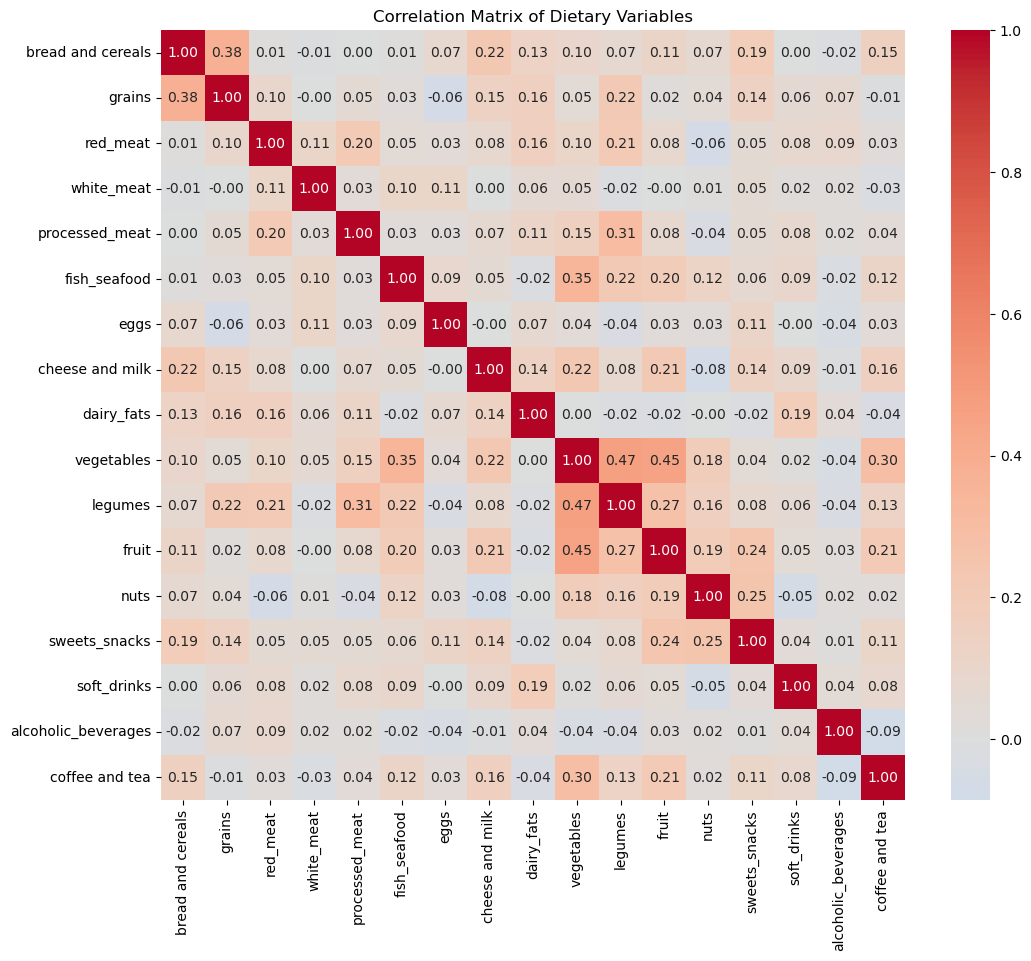

In [17]:
### Check Redundancy via Correlation Matrix
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = aggregated_data.drop(columns=['ID_paziente']).corr()
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Dietary Variables")
plt.show()

In [18]:
# Calculate mean and variance for all columns in aggregated_data (excluding ID_paziente)
food_category_columns = [col for col in aggregated_data.columns if col != 'ID_paziente']

# Calculate statistics
statistics = pd.DataFrame({
    'Mean': aggregated_data[food_category_columns].mean(),
    'Variance': aggregated_data[food_category_columns].var()
})

print("Mean and Variance for all food categories:")
print(statistics.round(4))

Mean and Variance for all food categories:
                       Mean  Variance
bread and cereals    1.8347    1.8329
grains               1.1716    0.7647
red_meat             0.2802    0.0607
white_meat           0.2695    0.0839
processed_meat       0.2540    0.1005
fish_seafood         0.4123    0.0866
eggs                 0.1870    0.0381
cheese and milk      1.7001    1.4401
dairy_fats           0.1829    0.1595
vegetables           3.9562   11.6925
legumes              0.6091    0.4481
fruit                7.7254   53.4458
nuts                 0.6340    1.3644
sweets_snacks        1.5687    1.6714
soft_drinks          0.4816    0.7746
alcoholic_beverages  0.6448    1.0529
coffee and tea       2.6421    3.7296


we need to check the density of all the food groups to see what further data manipulation is needed


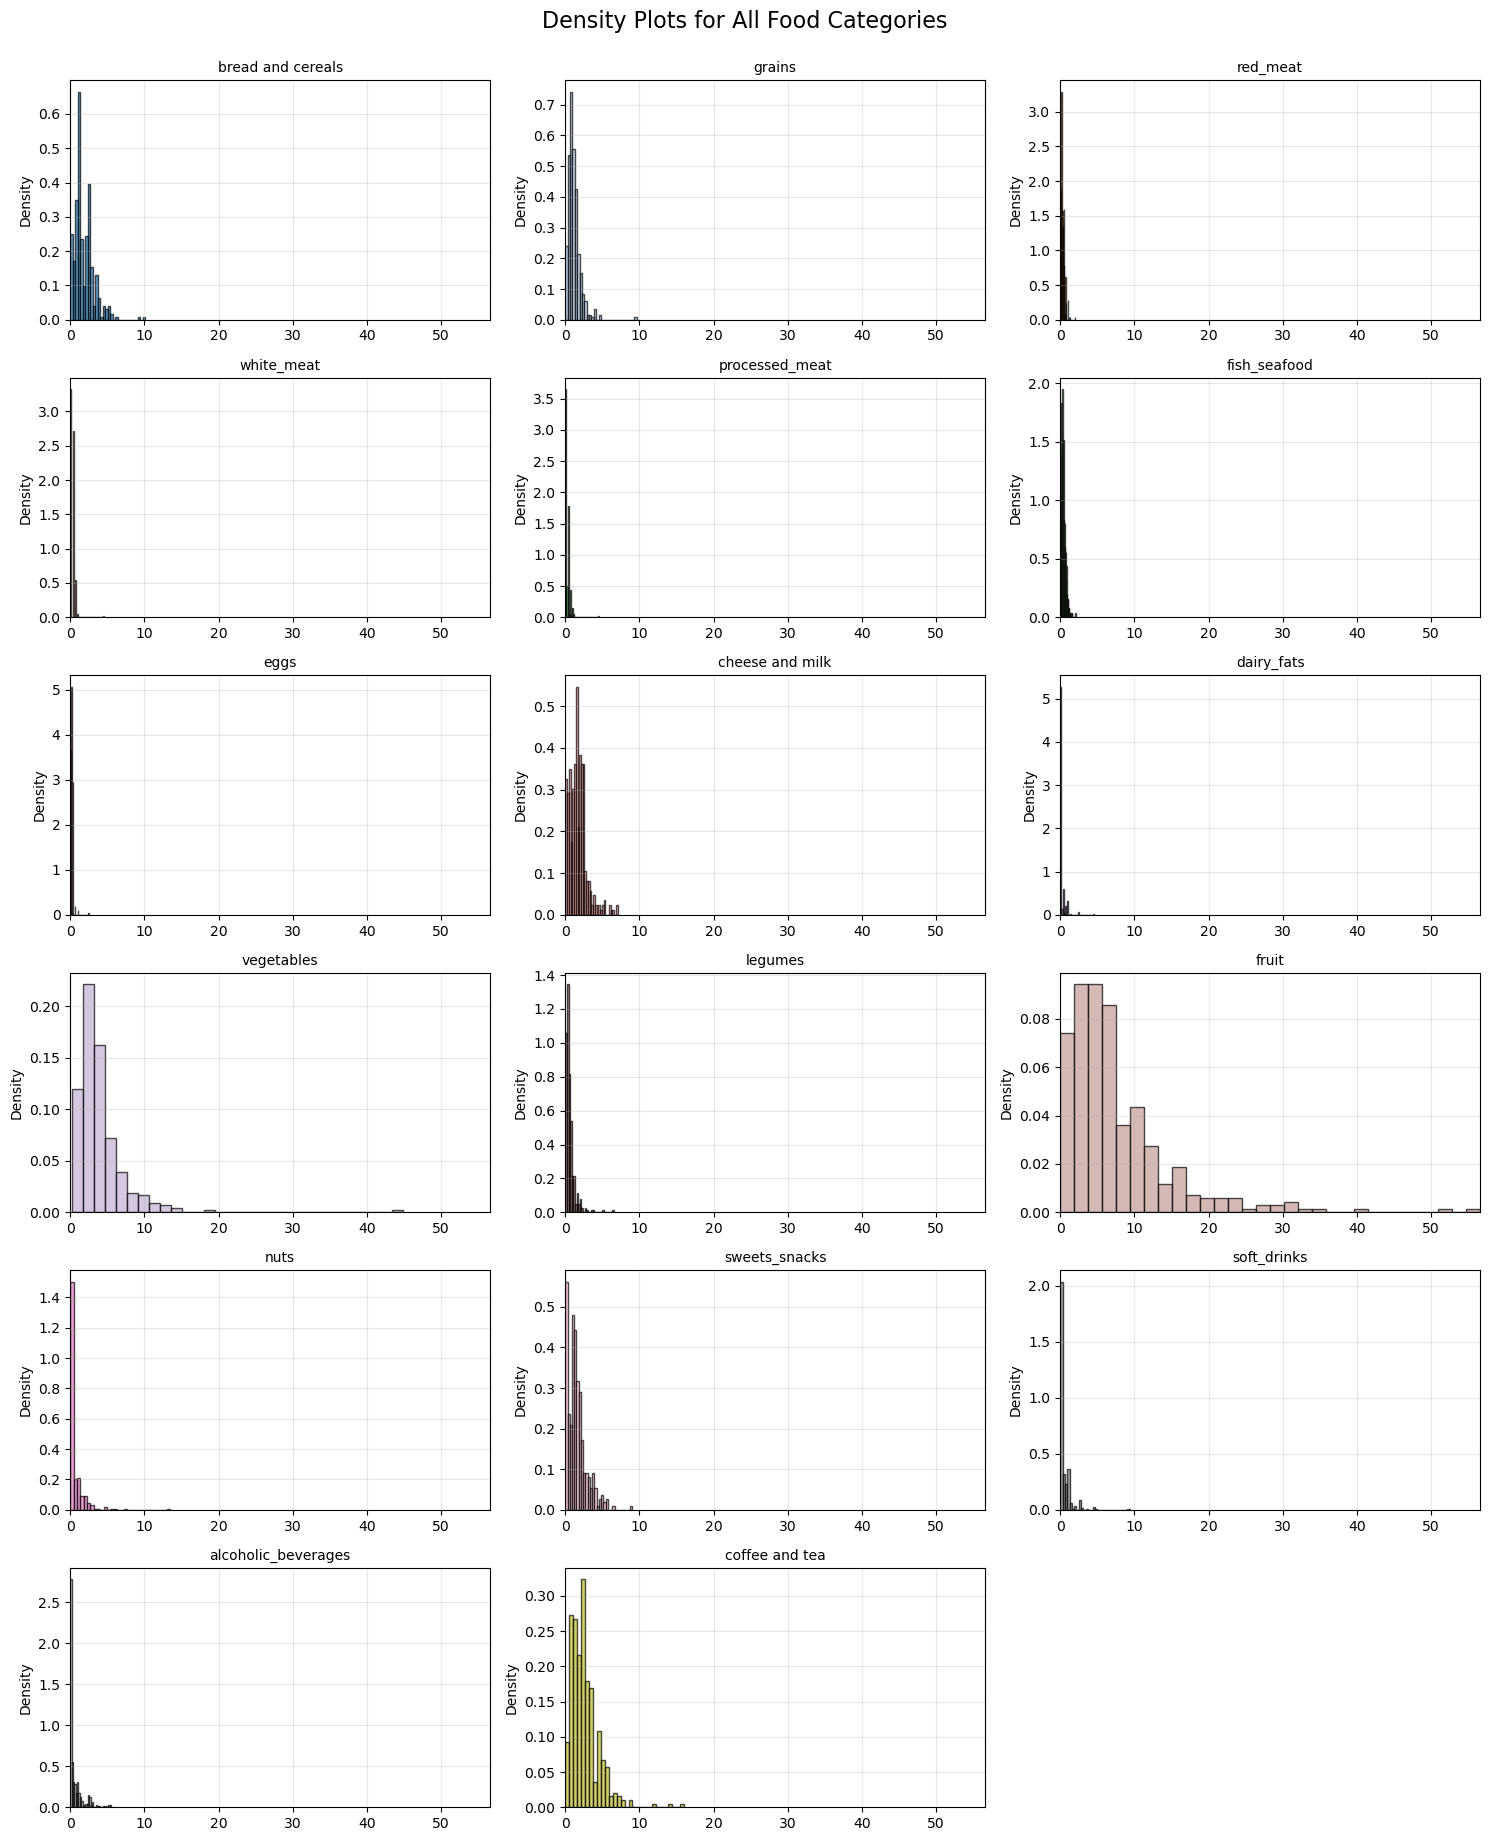

In [19]:

# Set up the plot with subplots for all food categories
fig, axes = plt.subplots(6, 3, figsize=(15, 18))
axes = axes.flatten()

# Get the overall range for x-axis to keep them consistent
all_data = []
for col in food_category_columns:
    all_data.extend(aggregated_data[col].values)

x_min, x_max = min(all_data), max(all_data)

# Plot density for each food category
for i, col in enumerate(food_category_columns):
    axes[i].hist(aggregated_data[col], bins=30, density=True, alpha=0.7, 
                 edgecolor='black', color=plt.cm.tab20(i))
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_ylabel('Density')
    axes[i].grid(True, alpha=0.3)

# Remove extra subplots
for i in range(len(food_category_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Density Plots for All Food Categories', fontsize=16, y=1.02)
plt.show()

based on the desity plot we need to apply some transformations before running our models because they are right skewed and zero inflated

In [20]:
# Import additional libraries for transformations
from scipy import stats
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

# Check skewness for each food category
skewness_results = {}
for col in food_category_columns:
    skewness = aggregated_data[col].skew()
    skewness_results[col] = skewness
    
# Display skewness results
skew_df = pd.DataFrame(list(skewness_results.items()), columns=['Food_Category', 'Skewness'])
skew_df = skew_df.sort_values('Skewness', ascending=False)
print("Skewness by food category:")
print("(>1 = highly right-skewed, >0.5 = moderately skewed)")
print(skew_df.round(3))

Skewness by food category:
(>1 = highly right-skewed, >0.5 = moderately skewed)
          Food_Category  Skewness
3            white_meat     8.794
4        processed_meat     7.144
8            dairy_fats     5.618
9            vegetables     5.492
6                  eggs     5.428
12                 nuts     5.341
14          soft_drinks     4.591
10              legumes     3.927
1                grains     3.450
11                fruit     2.674
15  alcoholic_beverages     2.371
16       coffee and tea     2.317
2              red_meat     1.947
0     bread and cereals     1.711
13        sweets_snacks     1.525
5          fish_seafood     1.476
7       cheese and milk     1.428


In [21]:
# Check for zeros in each category and apply transformations
transformed_data = aggregated_data.copy()

print("Transformation plan based on skewness:")
print("=" * 50)

for col in food_category_columns:
    skew_value = aggregated_data[col].skew()
    has_zeros = (aggregated_data[col] == 0).any()
    zero_count = (aggregated_data[col] == 0).sum()
    
    print(f"\n{col}:")
    print(f"  Skewness: {skew_value:.3f}")
    print(f"  Has zeros: {has_zeros} ({zero_count} zeros)")
    
    if skew_value > 3:  # Extremely skewed
        if has_zeros:
            # Log transformation with small constant
            transformed_data[col + '_log'] = np.log(aggregated_data[col] + 0.01)
            print(f"  → Applied: log(x + 0.01)")
        else:
            transformed_data[col + '_log'] = np.log(aggregated_data[col])
            print(f"  → Applied: log(x)")
            
    elif skew_value > 1:  # Highly skewed
        # Square root transformation
        transformed_data[col + '_sqrt'] = np.sqrt(aggregated_data[col])
        print(f"  → Applied: sqrt(x)")
        
    else:  # Moderately skewed
        # Keep original
        transformed_data[col + '_original'] = aggregated_data[col]
        print(f"  → Kept original")

Transformation plan based on skewness:

bread and cereals:
  Skewness: 1.711
  Has zeros: True (2 zeros)
  → Applied: sqrt(x)

grains:
  Skewness: 3.450
  Has zeros: True (4 zeros)
  → Applied: log(x + 0.01)

red_meat:
  Skewness: 1.947
  Has zeros: True (24 zeros)
  → Applied: sqrt(x)

white_meat:
  Skewness: 8.794
  Has zeros: True (24 zeros)
  → Applied: log(x + 0.01)

processed_meat:
  Skewness: 7.144
  Has zeros: True (30 zeros)
  → Applied: log(x + 0.01)

fish_seafood:
  Skewness: 1.476
  Has zeros: True (8 zeros)
  → Applied: sqrt(x)

eggs:
  Skewness: 5.428
  Has zeros: True (25 zeros)
  → Applied: log(x + 0.01)

cheese and milk:
  Skewness: 1.428
  Has zeros: True (4 zeros)
  → Applied: sqrt(x)

dairy_fats:
  Skewness: 5.618
  Has zeros: True (129 zeros)
  → Applied: log(x + 0.01)

vegetables:
  Skewness: 5.492
  Has zeros: False (0 zeros)
  → Applied: log(x)

legumes:
  Skewness: 3.927
  Has zeros: True (5 zeros)
  → Applied: log(x + 0.01)

fruit:
  Skewness: 2.674
  Has zero

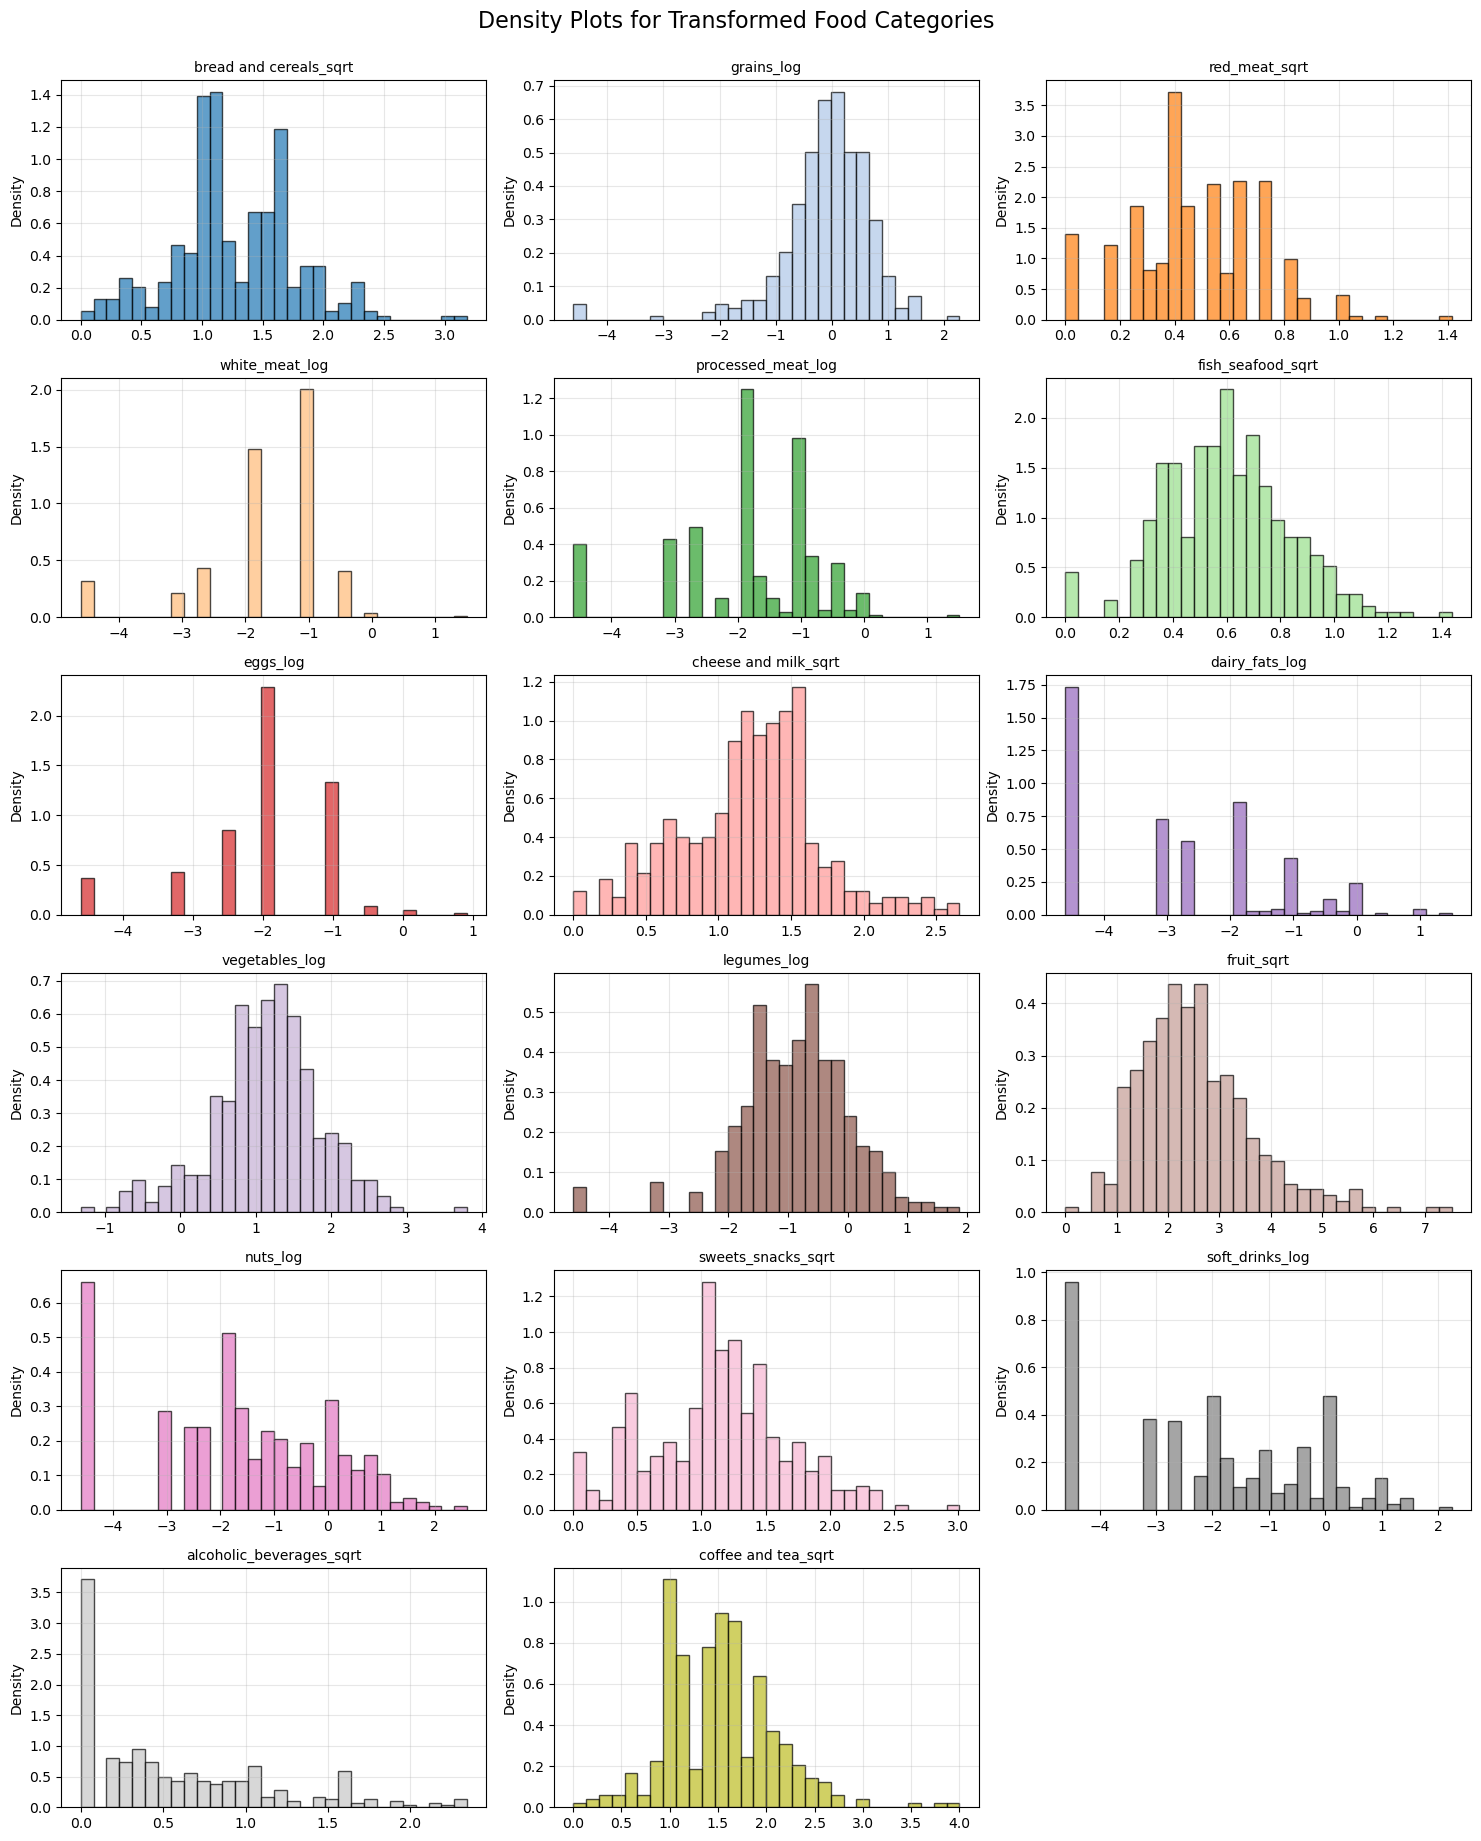

In [22]:
# Plot density for transformed variables
fig, axes = plt.subplots(6, 3, figsize=(15, 18))
axes = axes.flatten()

# Get the transformed columns (excluding original and ID)
transformed_columns = [col for col in transformed_data.columns 
                      if col not in food_category_columns and col != 'ID_paziente']

# Plot density for each transformed variable
for i, col in enumerate(transformed_columns):
    axes[i].hist(transformed_data[col], bins=30, density=True, alpha=0.7, 
                 edgecolor='black', color=plt.cm.tab20(i))
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_ylabel('Density')
    axes[i].grid(True, alpha=0.3)

# Remove extra subplots
for i in range(len(transformed_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Density Plots for Transformed Food Categories', fontsize=16, y=1.02)
plt.show()

In [23]:
# First, let's check the current transformed dataset structure
print("Transformed columns:")
print(transformed_columns)
print(f"\nTransformed dataset shape: {transformed_data.shape}")

Transformed columns:
['bread and cereals_sqrt', 'grains_log', 'red_meat_sqrt', 'white_meat_log', 'processed_meat_log', 'fish_seafood_sqrt', 'eggs_log', 'cheese and milk_sqrt', 'dairy_fats_log', 'vegetables_log', 'legumes_log', 'fruit_sqrt', 'nuts_log', 'sweets_snacks_sqrt', 'soft_drinks_log', 'alcoholic_beverages_sqrt', 'coffee and tea_sqrt']

Transformed dataset shape: (365, 35)


now that we have transformed all the variables, we will be dealing with their outliers 

In [24]:
# Create clean dataset with only ID and transformed columns
clean_data = pd.DataFrame()
clean_data['ID_paziente'] = transformed_data['ID_paziente']

# Add only the transformed columns
for col in transformed_columns:
    clean_data[col] = transformed_data[col]

print(f"Clean dataset shape: {clean_data.shape}")
print("Columns:", clean_data.columns.tolist())

Clean dataset shape: (365, 18)
Columns: ['ID_paziente', 'bread and cereals_sqrt', 'grains_log', 'red_meat_sqrt', 'white_meat_log', 'processed_meat_log', 'fish_seafood_sqrt', 'eggs_log', 'cheese and milk_sqrt', 'dairy_fats_log', 'vegetables_log', 'legumes_log', 'fruit_sqrt', 'nuts_log', 'sweets_snacks_sqrt', 'soft_drinks_log', 'alcoholic_beverages_sqrt', 'coffee and tea_sqrt']


we cap them at 99th percentile

In [25]:
# Cap outliers at 99th percentile (preserve zeros)
final_data = clean_data.copy()

for col in transformed_columns:
    # Cap at 99th percentile
    upper_limit = clean_data[col].quantile(0.95)
    final_data[col] = clean_data[col].clip(upper=upper_limit)
    
    # Show what we did
    outliers_capped = (clean_data[col] > upper_limit).sum()
    print(f"{col}: capped {outliers_capped} outliers above {upper_limit:.3f}")

print(f"\nFinal dataset shape: {final_data.shape}")
final_data.head()

bread and cereals_sqrt: capped 19 outliers above 2.104
grains_log: capped 19 outliers above 0.970
red_meat_sqrt: capped 16 outliers above 0.845
white_meat_log: capped 4 outliers above -0.426
processed_meat_log: capped 17 outliers above -0.377
fish_seafood_sqrt: capped 18 outliers above 0.981
eggs_log: capped 10 outliers above -1.002
cheese and milk_sqrt: capped 19 outliers above 1.976
dairy_fats_log: capped 5 outliers above 0.010
vegetables_log: capped 19 outliers above 2.243
legumes_log: capped 19 outliers above 0.560
fruit_sqrt: capped 19 outliers above 4.665
nuts_log: capped 19 outliers above 0.920
sweets_snacks_sqrt: capped 19 outliers above 2.007
soft_drinks_log: capped 19 outliers above 0.760
alcoholic_beverages_sqrt: capped 19 outliers above 1.634
coffee and tea_sqrt: capped 17 outliers above 2.420

Final dataset shape: (365, 18)


,ID_paziente,bread and cereals_sqrt,grains_log,red_meat_sqrt,white_meat_log,processed_meat_log,fish_seafood_sqrt,eggs_log,cheese and milk_sqrt,dairy_fats_log,vegetables_log,legumes_log,fruit_sqrt,nuts_log,sweets_snacks_sqrt,soft_drinks_log,alcoholic_beverages_sqrt,coffee and tea_sqrt
0,1,1.679002,0.621856,0.651007,-2.568288,-1.002004,0.483046,-2.568288,1.253566,-3.138833,0.023530,-2.207275,1.129686,-2.568288,0.774597,-1.942582,1.238278,1.581139
1,2,0.842332,-0.342490,0.651007,-1.002004,-1.878252,0.647339,-1.878252,1.133893,-1.878252,0.953678,0.194548,4.665271,-1.942582,1.348721,-1.733491,0.316228,1.581139
2,3,0.801784,0.730764,0.845154,-1.002004,-3.138833,0.980767,-1.878252,0.730297,-1.942582,1.314747,-0.390576,1.409154,-1.560648,1.222799,-0.329166,0.883715,1.016530
3,4,1.546116,-0.390576,0.597614,-1.002004,-1.002004,0.621059,-1.878252,1.251666,-2.568288,1.566630,-1.140923,1.780851,-0.376600,1.281740,-2.568288,0.316228,1.732051
4,5,1.048809,0.190620,0.377964,-2.568288,-3.138833,0.768424,-1.002004,1.473577,-3.138833,1.477266,-0.148058,3.251373,-4.605170,0.556349,-1.878252,0.883715,1.486447


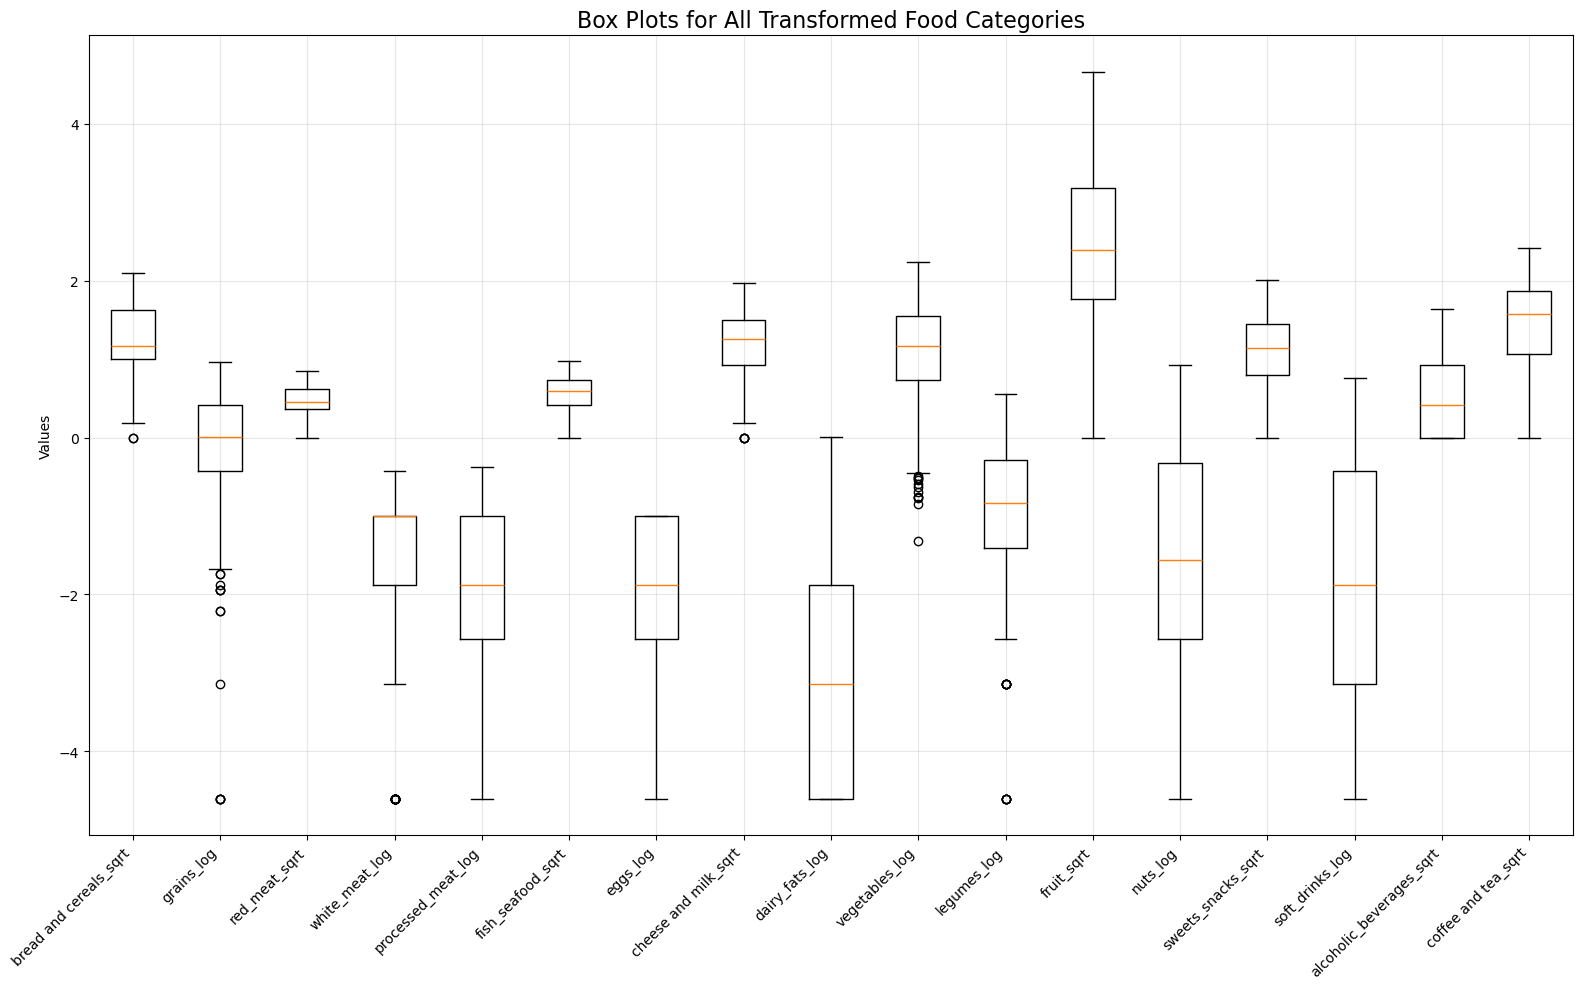

In [26]:
# Create box plots for all transformed food categories
plt.figure(figsize=(16, 10))

# Get the column names for transformed variables (excluding ID)
plot_columns = [col for col in final_data.columns if col != 'ID_paziente']

# Create box plot
plt.boxplot([final_data[col] for col in plot_columns], labels=plot_columns)
plt.xticks(rotation=45, ha='right')
plt.title('Box Plots for All Transformed Food Categories', fontsize=16)
plt.ylabel('Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

now we standardize all the values 

In [27]:
# # Standardize all transformed variables
# from sklearn.preprocessing import StandardScaler

# # Get feature columns (exclude ID)
# feature_columns = [col for col in final_data.columns if col != 'ID_paziente']

# # Create and fit the scaler
# scaler = StandardScaler()
# standardized_features = scaler.fit_transform(final_data[feature_columns])

# # Create final standardized dataset
# standardized_data = pd.DataFrame(standardized_features, columns=feature_columns)
# standardized_data['ID_paziente'] = final_data['ID_paziente']

# # Reorder columns to put ID first
# standardized_data = standardized_data[['ID_paziente'] + feature_columns]

# print(f"Standardized dataset shape: {standardized_data.shape}")
# print("\nFirst 5 rows:")
# standardized_data.head()

## Discovering dietary patterns with Gaussian Mixture Models (GMM)

### Use BIC and AIC 

In [28]:
df_gmm = final_data.copy()

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
diet_vars = [col for col in df_gmm.columns if col != 'ID_paziente']
scaler = StandardScaler()
X_diet = scaler.fit_transform(df_gmm[diet_vars])

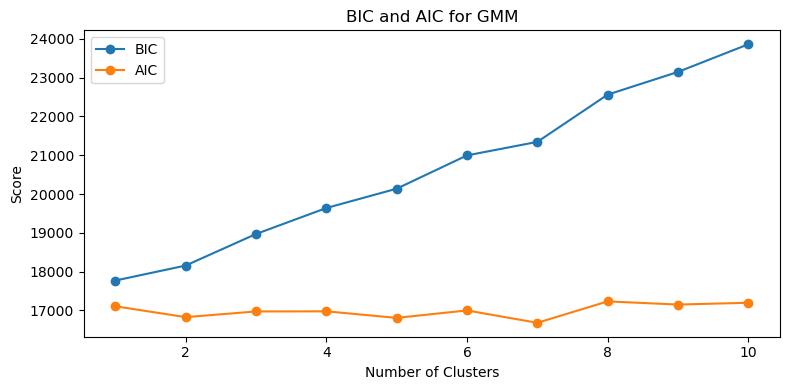

In [31]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components = np.arange(1, 11)  # Try 1 to 10 clusters
bics = []
aics = []

for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_diet)  # Assuming your input data is scaled
    bics.append(gmm.bic(X_diet))
    aics.append(gmm.aic(X_diet))

# Plot BIC and AIC
plt.figure(figsize=(8, 4))
plt.plot(n_components, bics, label='BIC', marker='o')
plt.plot(n_components, aics, label='AIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('BIC and AIC for GMM')
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters (latent classes)
n_components = 3  # You can try 2, 3, 4, etc. and compare AIC/BIC

gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X_diet)

# Get cluster probabilities for each subject
pattern_probs = gmm.predict_proba(X_diet)

# Assign most likely pattern to each subject
pattern_labels = gmm.predict(X_diet)

df_gmm['diet_pattern'] = pattern_labels

In [33]:
df_gmm.head()

,ID_paziente,bread and cereals_sqrt,grains_log,red_meat_sqrt,white_meat_log,processed_meat_log,fish_seafood_sqrt,eggs_log,cheese and milk_sqrt,dairy_fats_log,vegetables_log,legumes_log,fruit_sqrt,nuts_log,sweets_snacks_sqrt,soft_drinks_log,alcoholic_beverages_sqrt,coffee and tea_sqrt,diet_pattern
0,1,1.679002,0.621856,0.651007,-2.568288,-1.002004,0.483046,-2.568288,1.253566,-3.138833,0.023530,-2.207275,1.129686,-2.568288,0.774597,-1.942582,1.238278,1.581139,1
1,2,0.842332,-0.342490,0.651007,-1.002004,-1.878252,0.647339,-1.878252,1.133893,-1.878252,0.953678,0.194548,4.665271,-1.942582,1.348721,-1.733491,0.316228,1.581139,1
2,3,0.801784,0.730764,0.845154,-1.002004,-3.138833,0.980767,-1.878252,0.730297,-1.942582,1.314747,-0.390576,1.409154,-1.560648,1.222799,-0.329166,0.883715,1.016530,1
3,4,1.546116,-0.390576,0.597614,-1.002004,-1.002004,0.621059,-1.878252,1.251666,-2.568288,1.566630,-1.140923,1.780851,-0.376600,1.281740,-2.568288,0.316228,1.732051,1
4,5,1.048809,0.190620,0.377964,-2.568288,-3.138833,0.768424,-1.002004,1.473577,-3.138833,1.477266,-0.148058,3.251373,-4.605170,0.556349,-1.878252,0.883715,1.486447,0


In [34]:
# count the number of subjects in each pattern
df_gmm['diet_pattern'].value_counts()

diet_pattern
1    237
2     68
0     60
Name: count, dtype: int64

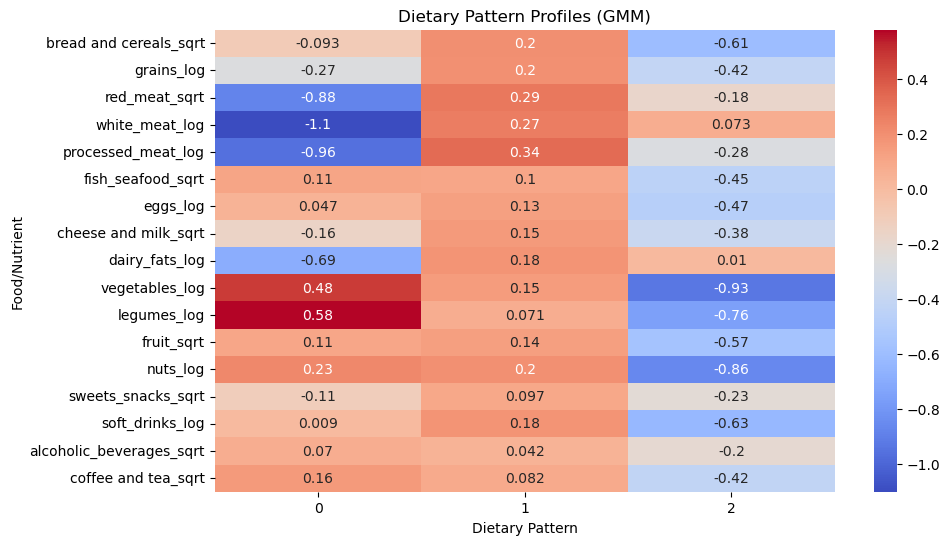

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

pattern_means = pd.DataFrame(gmm.means_, columns=diet_vars)

plt.figure(figsize=(10, 6))
sns.heatmap(pattern_means.T, annot=True, cmap='coolwarm')
plt.title('Dietary Pattern Profiles (GMM)')
plt.xlabel('Dietary Pattern')
plt.ylabel('Food/Nutrient')
plt.show()

In [36]:
from sklearn.metrics import silhouette_samples, silhouette_score

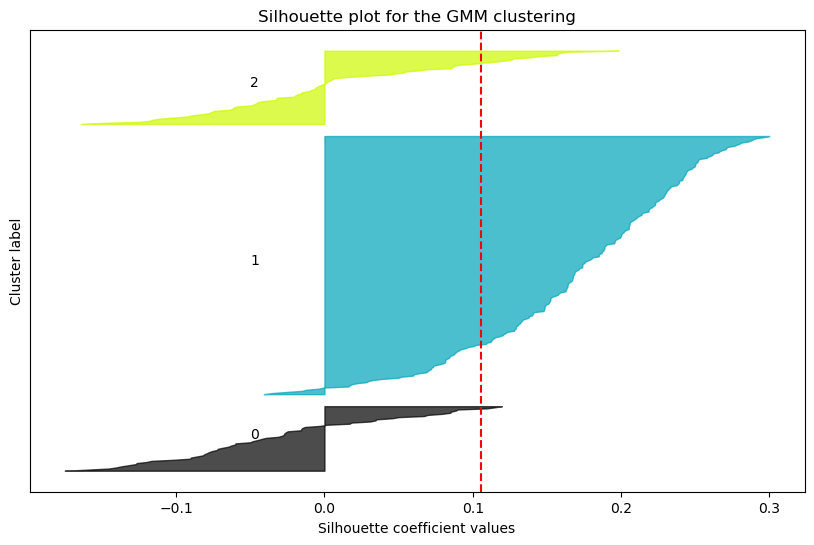

In [37]:
# 3. Silhouette analysis
silhouette_avg = silhouette_score(X_diet, pattern_labels)
sample_silhouette_values = silhouette_samples(X_diet, pattern_labels)

# 4. Plot
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
n_clusters = np.unique(pattern_labels).shape[0]

for i in range(n_clusters):
    # Aggregate silhouette scores for samples in cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[pattern_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # space between plots

# Plot average silhouette score
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title("Silhouette plot for the GMM clustering")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_yticks([])  # Clear the yaxis pattern_labels / ticks
plt.show()

## Discovering dietary patterns with LCA

In [38]:
df_lca = final_data.copy()

In [39]:
# Function for quantile-based binning with 0 as separate category
def quantile_bin_with_zero(series, q=3):
    # Replace 0 with NaN temporarily so they don't affect quantiles
    non_zero = series[series > 0]
    
    # Perform qcut on non-zero values
    try:
        binned = pd.qcut(non_zero, q=q, labels=range(1, q+1), duplicates='drop')
    except ValueError:
        # Not enough unique values — fallback to single category
        binned = pd.Series(index=non_zero.index, data=1)
    
    # Create full series
    result = pd.Series(data=0, index=series.index)  # Start with zeros
    result.loc[binned.index] = binned.astype(int)   # Fill non-zeros
    return result


for col in diet_vars:
    df_lca[col] = quantile_bin_with_zero(df_lca[col], q=3)  #5 categories

df_lca.head()

,ID_paziente,bread and cereals_sqrt,grains_log,red_meat_sqrt,white_meat_log,processed_meat_log,fish_seafood_sqrt,eggs_log,cheese and milk_sqrt,dairy_fats_log,vegetables_log,legumes_log,fruit_sqrt,nuts_log,sweets_snacks_sqrt,soft_drinks_log,alcoholic_beverages_sqrt,coffee and tea_sqrt
0,1,3,3,3,0,0,1,0,2,0,1,0,1,0,1,0,3,2
1,2,1,0,3,0,0,2,0,2,0,1,1,3,0,3,0,1,2
2,3,1,3,3,0,0,3,0,1,0,2,0,1,0,2,0,2,1
3,4,3,0,2,0,0,2,0,2,0,3,0,1,0,2,0,1,3
4,5,2,1,1,0,0,3,0,3,0,3,0,3,0,1,0,2,2


In [40]:
X_diet_lca = [col for col in df_lca.columns if col != 'ID_paziente']

In [41]:
from stepmix.stepmix import StepMix

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 76.91it/s, max_LL=-5.25e+3, max_avg_LL=-14.4]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  5.88it/s, max_LL=-5.12e+3, max_avg_LL=-14]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, max_LL=-5.07e+3, max_avg_LL=-13.9]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  3.19it/s, max_LL=-5.02e+3, max_avg_LL=-13.8]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  3.94it/s, max_LL=-4.98e+3, max_avg_LL=-13.6]


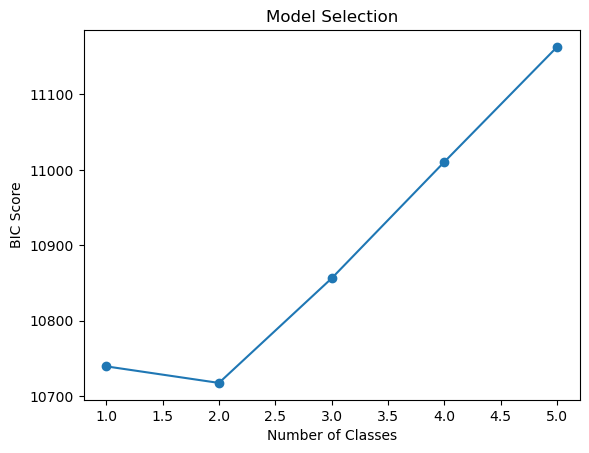

In [42]:
bic_scores = []
for k in range(1, 6):
    model = StepMix(n_components=k, measurement='categorical', n_steps=1, random_state=42)
    model.fit(df_lca[X_diet_lca])
    bic_scores.append(model.bic(df_lca[X_diet_lca]))

import matplotlib.pyplot as plt
plt.plot(range(1, 6), bic_scores, marker='o')
plt.xlabel("Number of Classes")
plt.ylabel("BIC Score")
plt.title("Model Selection")
plt.show()


In [43]:
# Number of classes you want to try (e.g. 2, 3, or 4)
n_classes = 3

# Fit the LCA model
model = StepMix(n_components=n_classes, measurement='categorical', n_steps=1, verbose=1, random_state=42)
model.fit(df_lca[X_diet_lca])

# Get predicted class (latent profile) for each individual
class_assignments = model.predict(df_lca[X_diet_lca])

# Add class labels to your original dataframe
df_lca['diet_pattern_LCA'] = class_assignments


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, max_LL=-5.07e+3, max_avg_LL=-13.9]

MODEL REPORT
    Measurement model parameters
          model_name                       categorical                
          class_no                                   0       1       2
          param variable                                              
          pis   alcoholic_beverages_sqrt_0      0.2276  0.3164  0.3245
                alcoholic_beverages_sqrt_1      0.2720  0.2400  0.2469
                alcoholic_beverages_sqrt_2      0.2812  0.2389  0.2078
                alcoholic_beverages_sqrt_3      0.2192  0.2047  0.2208
                bread and cereals_sqrt_0        0.0000  0.0000  0.0200
                bread and cereals_sqrt_1        0.0000  0.6478  0.2727
                bread and cereals_sqrt_2        0.6121  0.1970  0.1872
                bread and cereals_sqrt_3        0.3879  0.1552  0.5201
                cheese and milk_sqrt_0          0.0173  0.0068  0.0099
                cheese and milk_sqrt_1          0.1626  0.5012  0.2634
                cheese and milk

In [44]:
df_lca['diet_pattern_LCA'].value_counts()

diet_pattern_LCA
1    148
0    118
2     99
Name: count, dtype: int64

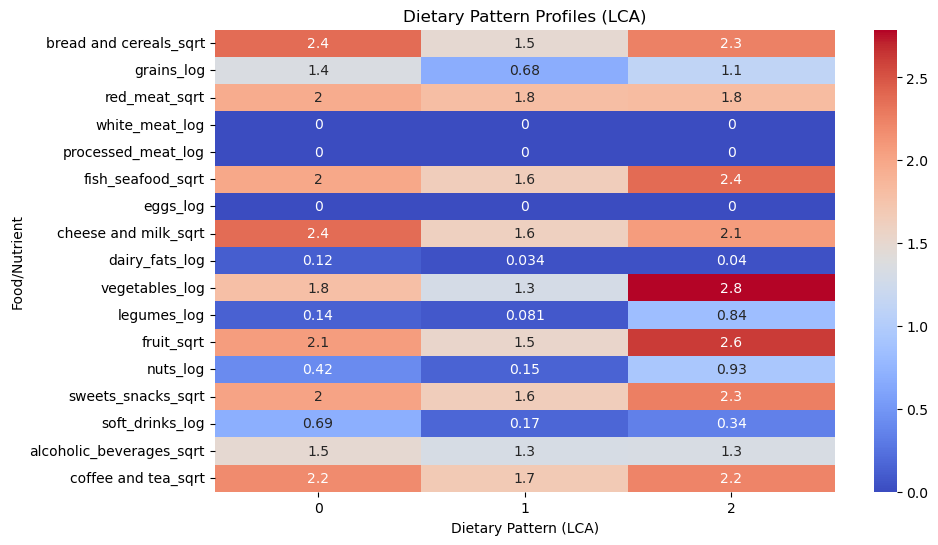

In [45]:
# Prepare data for plotting
pattern_means_lca = df_lca.groupby('diet_pattern_LCA')[diet_vars].mean().T
plt.figure(figsize=(10, 6))
sns.heatmap(pattern_means_lca, annot=True, cmap='coolwarm')
plt.title('Dietary Pattern Profiles (LCA)')
plt.xlabel('Dietary Pattern (LCA)')
plt.ylabel('Food/Nutrient')
plt.show()

## OLS with GMM

In [46]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [47]:
# keep only 'DAS28', 'ETA_VISITA', 'SESSO', 'BMI', 'DURATA_MALATTIA', 'Fattore_reumatoide', 'STEROIDI', 'bDMARDs', 'Fumatore', 'ID_paziente' from df
df_temp = df[['DAS28', 'ETA_VISITA', 'SESSO', 'BMI', 'DURATA_MALATTIA',
                   'Fattore_reumatoide', 'STEROIDI', 'bDMARDs', 'Fumatore', 'ID_paziente']].copy()
df_temp.head()

,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore,ID_paziente
0,3.660762,40.59,Maschio,26.312811,7.61,VERO,VERO,VERO,Fumatore,1
1,1.796643,37.38,Femmina,21.551020,11.64,FALSO,FALSO,FALSO,Non fumatore,2
2,2.465101,40.36,Femmina,20.069204,8.61,VERO,FALSO,FALSO,Non fumatore,3
3,3.133907,50.41,Femmina,25.099502,29.62,FALSO,VERO,FALSO,Ex-fumatore,4
4,2.794231,67.70,Femmina,30.859375,13.18,FALSO,FALSO,FALSO,Ex-fumatore,5


In [48]:
# vero-1, falso-0 for categorical columns (Fattore_reumatoide	STEROIDI	bDMARDs)
categorical_columns = ['Fattore_reumatoide', 'STEROIDI', 'bDMARDs']
for col in categorical_columns:
    df_temp[col] = df_temp[col].map({'VERO': 1, 'FALSO': 0})

# SESSO column: 0 for 'M', 1 for 'F'
df_temp['SESSO'] = df_temp['SESSO'].map({'Maschio': 0, 'Femmina': 1})

# Fumatore column:0,1,2 for 'non fumatori', 'ex fumatori', 'fumatori'
df_temp['Fumatore'] = df_temp['Fumatore'].map({'Non fumatore': 0, 'Ex-fumatore': 1, 'Fumatore': 2})

df_temp['DAS28'] = df_temp['DAS28'].astype(float)

df_temp.head()

,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore,ID_paziente
0,3.660762,40.59,0,26.312811,7.61,1,1,1,2.0,1
1,1.796643,37.38,1,21.551020,11.64,0,0,0,0.0,2
2,2.465101,40.36,1,20.069204,8.61,1,0,0,0.0,3
3,3.133907,50.41,1,25.099502,29.62,0,1,0,1.0,4
4,2.794231,67.70,1,30.859375,13.18,0,0,0,1.0,5


In [49]:
# number of null values in each column
df_temp.isnull().sum()

DAS28                 0
ETA_VISITA            0
SESSO                 0
BMI                   0
DURATA_MALATTIA       0
Fattore_reumatoide    0
STEROIDI              0
bDMARDs               0
Fumatore              3
ID_paziente           0
dtype: int64

In [50]:
# drop rows with any null values
df_temp = df_temp.dropna()
df_temp['Fumatore'] = df_temp['Fumatore'].astype(int)

In [51]:
# merge df_temp with df_gmm on 'ID_paziente'
df_gmm = df_gmm.merge(df_temp, on='ID_paziente', how='left')
df_gmm.head()

,ID_paziente,bread and cereals_sqrt,grains_log,red_meat_sqrt,white_meat_log,processed_meat_log,fish_seafood_sqrt,eggs_log,cheese and milk_sqrt,dairy_fats_log,...,diet_pattern,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,1,1.679002,0.621856,0.651007,-2.568288,-1.002004,0.483046,-2.568288,1.253566,-3.138833,...,1,3.660762,40.59,0.0,26.312811,7.61,1.0,1.0,1.0,2.0
1,2,0.842332,-0.342490,0.651007,-1.002004,-1.878252,0.647339,-1.878252,1.133893,-1.878252,...,1,1.796643,37.38,1.0,21.551020,11.64,0.0,0.0,0.0,0.0
2,3,0.801784,0.730764,0.845154,-1.002004,-3.138833,0.980767,-1.878252,0.730297,-1.942582,...,1,2.465101,40.36,1.0,20.069204,8.61,1.0,0.0,0.0,0.0
3,4,1.546116,-0.390576,0.597614,-1.002004,-1.002004,0.621059,-1.878252,1.251666,-2.568288,...,1,3.133907,50.41,1.0,25.099502,29.62,0.0,1.0,0.0,1.0
4,5,1.048809,0.190620,0.377964,-2.568288,-3.138833,0.768424,-1.002004,1.473577,-3.138833,...,0,2.794231,67.70,1.0,30.859375,13.18,0.0,0.0,0.0,1.0


In [52]:
df_gmm['diet_pattern'] = df_gmm['diet_pattern'].astype('category')

# Define confounders after encoding
confounders = [
    'BMI',
    'ETA_VISITA',
    'DURATA_MALATTIA',
    'Fattore_reumatoide',
    'STEROIDI',
    'bDMARDs',
    'SESSO',
    'Fumatore'
]

formula = 'DAS28 ~ C(diet_pattern) + ' + ' + '.join(confounders)
model = smf.ols(formula=formula, data=df_gmm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  DAS28   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5.272
Date:                Wed, 28 May 2025   Prob (F-statistic):           3.07e-07
Time:                        18:16:28   Log-Likelihood:                -527.74
No. Observations:                 362   AIC:                             1077.
Df Residuals:                     351   BIC:                             1120.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.3974 

In [53]:
from statsmodels.stats.anova import anova_lm
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(diet_pattern),2.0,6.679107,3.339553,2.995656,5.128398e-02
BMI,1.0,8.759644,8.759644,7.857603,5.341887e-03
ETA_VISITA,1.0,0.118320,0.118320,0.106136,7.447811e-01
DURATA_MALATTIA,1.0,6.894073,6.894073,6.184143,1.335412e-02
Fattore_reumatoide,1.0,0.030743,0.030743,0.027577,8.682031e-01
STEROIDI,1.0,28.213590,28.213590,25.308242,7.815218e-07
bDMARDs,1.0,7.612339,7.612339,6.828444,9.357654e-03
SESSO,1.0,0.427382,0.427382,0.383371,5.362061e-01
Fumatore,1.0,0.035122,0.035122,0.031505,8.592209e-01
Residual,351.0,391.294268,1.114798,NaN,NaN


## OLS with LCA

In [54]:
# merge df_temp with df_lca on 'ID_paziente'
df_lca = df_lca.merge(df_temp, on='ID_paziente', how='left')
df_lca.head()

,ID_paziente,bread and cereals_sqrt,grains_log,red_meat_sqrt,white_meat_log,processed_meat_log,fish_seafood_sqrt,eggs_log,cheese and milk_sqrt,dairy_fats_log,...,diet_pattern_LCA,DAS28,ETA_VISITA,SESSO,BMI,DURATA_MALATTIA,Fattore_reumatoide,STEROIDI,bDMARDs,Fumatore
0,1,3,3,3,0,0,1,0,2,0,...,0,3.660762,40.59,0.0,26.312811,7.61,1.0,1.0,1.0,2.0
1,2,1,0,3,0,0,2,0,2,0,...,1,1.796643,37.38,1.0,21.551020,11.64,0.0,0.0,0.0,0.0
2,3,1,3,3,0,0,3,0,1,0,...,1,2.465101,40.36,1.0,20.069204,8.61,1.0,0.0,0.0,0.0
3,4,3,0,2,0,0,2,0,2,0,...,0,3.133907,50.41,1.0,25.099502,29.62,0.0,1.0,0.0,1.0
4,5,2,1,1,0,0,3,0,3,0,...,2,2.794231,67.70,1.0,30.859375,13.18,0.0,0.0,0.0,1.0


In [55]:
# OLS with LCA patterns
df_lca['diet_pattern_LCA'] = df_lca['diet_pattern_LCA'].astype('category')
formula_lca = 'DAS28 ~ C(diet_pattern_LCA) + ' + ' + '.join(confounders)
model_lca = smf.ols(formula=formula_lca, data=df_lca).fit()
print(model_lca.summary())

                            OLS Regression Results                            
Dep. Variable:                  DAS28   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.006
Date:                Wed, 28 May 2025   Prob (F-statistic):           8.24e-07
Time:                        18:16:29   Log-Likelihood:                -528.93
No. Observations:                 362   AIC:                             1080.
Df Residuals:                     351   BIC:                             1123.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [56]:
anova_lm(model_lca)

,df,sum_sq,mean_sq,F,PR(>F)
C(diet_pattern_LCA),2.0,1.018549,0.509274,0.453826,6.355653e-01
BMI,1.0,9.627445,9.627445,8.579238,3.622390e-03
ETA_VISITA,1.0,0.035586,0.035586,0.031711,8.587652e-01
DURATA_MALATTIA,1.0,5.577854,5.577854,4.970555,2.641461e-02
Fattore_reumatoide,1.0,0.000008,0.000008,0.000007,9.978697e-01
STEROIDI,1.0,30.644232,30.644232,27.307784,2.983468e-07
bDMARDs,1.0,8.903663,8.903663,7.934260,5.125082e-03
SESSO,1.0,0.314891,0.314891,0.280606,5.966390e-01
Fumatore,1.0,0.057395,0.057395,0.051146,8.212127e-01
Residual,351.0,393.884966,1.122179,NaN,NaN
